In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


%matplotlib inline

# DEIM 

We implemented DEIM with pivoted QR. DEIM was proposed in reference 1, but we follow the implemnetation in 2. 

1. Chaturantabut, Saifon, and Danny C. Sorensen. "Nonlinear model reduction via discrete empirical interpolation." SIAM Journal on Scientific Computing 32.5 (2010): 2737-2764. 
2. Drmac, Zlatko, and Serkan Gugercin. "A new selection operator for the discrete empirical interpolation method---improved a priori error bound and extensions." SIAM Journal on Scientific Computing 38.2 (2016): A631-A648.

For an application to sensor placement, read

3. Manohar, Krithika, et al. "Data-driven sparse sensor placement for reconstruction: Demonstrating the benefits of exploiting known patterns." IEEE Control Systems Magazine 38.3 (2018): 63-86.

In [2]:
from scipy.linalg import qr

def deim_pqr(S, k):
    u,s,_ = np.linalg.svd(S, full_matrices=False)
    u = u[:,:k]

    #Compute the pivoted QR 
    _,_,p = qr(u.T, pivoting = True, mode = 'economic')

    return u, s, p[:k]

## Example 1: 1 spatial dimension

Consider the function 
$$ f(t;\mu) = 10\exp(-\mu t) (\cos(4\mu t) + \sin(4\mu t)), \qquad 1 \leq t \leq 6, 0 \leq \mu \leq \pi.$$

Want to interpolate this function in $t$ for several parameters $\mu$. This example is from reference 2.

### Training phase

Text(0.5, 1.0, 'Singular values of snapshot matrix')

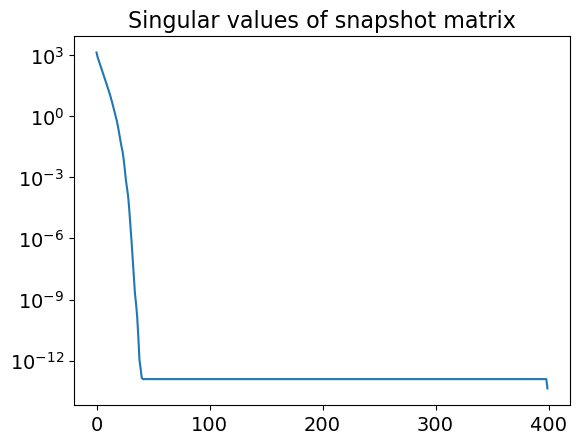

In [3]:
# Generate the snapshot matrix
mu_train = np.linspace(0,np.pi, 400)
t = np.linspace(1,6,1000)

f = lambda mu, t: 10*np.exp(-mu*t)*(np.cos(4*mu*t)+np.sin(4*mu*t))
M, T = np.meshgrid(mu_train, t)
S = f(M, T)

u, s, p = deim_pqr(S, 20)
plt.semilogy(s)
plt.title('Singular values of snapshot matrix', fontsize=16)

### Testing phase

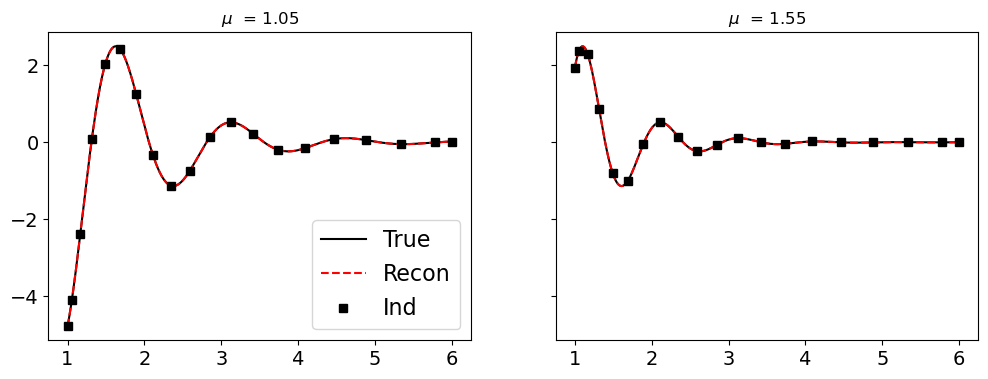

In [4]:
mu_test = np.pi*np.random.rand(100)
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize=(12,4))
mu1 = mu_test[0]
ft = f(mu1, t)
fr = u @ np.linalg.solve(u[p,:], ft[p])
ax1.plot(t, ft, 'k', t, fr, 'r--')
ax1.set_title( '$\mu$  = %.2f' % mu1)

ax1.plot(t[p], ft[p], 'ks')
ax1.legend(('True', 'Recon', 'Ind'), loc='best', fontsize=16)


mu2 = mu_test[1]
ft = f(mu2, t)
fr = u @ np.linalg.solve(u[p,:], ft[p])
ax2.plot(t, ft, 'k', t, fr, 'r--')
ax2.set_title('$\mu$  = %.2f' % mu2)

ax2.plot(t[p], ft[p], 'ks')
#ax1.plot(t, )

Text(0, 0.5, 'Relative error')

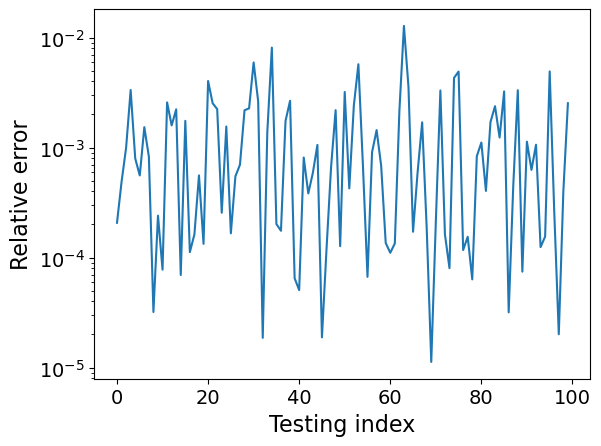

In [5]:
M, T = np.meshgrid(mu_test, t)
Ft = f(M, T)
Fr = u @ np.linalg.solve(u[p,:], Ft[p])

err = np.zeros((mu_test.size,))
for j in range(mu_test.size):
    err[j] = np.linalg.norm(Fr[:,j]-Ft[:,j])/np.linalg.norm(Ft[:,j])

plt.semilogy(range(mu_test.size), err)
plt.xlabel('Testing index', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

# Example 2: 2 spatial dimensions

Consider the function
$$ f(x,y;\mu_1,\mu_2) = \frac{1}{\sqrt{(x-\mu_1)^2 + (y-\mu_2)^2 + 0.1}}; \qquad \mu_1,\mu_2 \in [-1,-0.01]; (x,y) \in [0.1,0.9]^2. $$

Text(0.5, 1.0, 'Singular values of snapshot matrix')

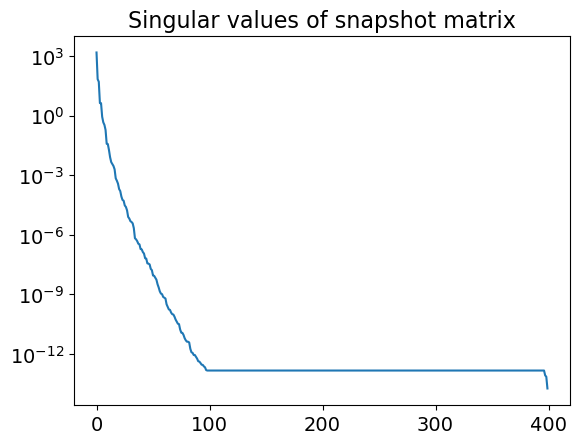

In [6]:
n = 100; N = n**2
x = np.linspace(0.1,0.9, n)
X,Y = np.meshgrid(x,x)

xpts = np.zeros((N,2)); 
xpts[:,0] = X.flatten(); xpts[:,1] = Y.flatten()

mu = np.linspace(-1,-0.01,20)
M1, M2 = np.meshgrid(mu,mu)
mu_train = np.zeros((400,2))
mu_train[:,0] = M1.flatten(); mu_train[:,1] = M2.flatten()

F = lambda X, mu : 1/np.sqrt( (X[:,0] - mu[0])**2. + (X[:,1] - mu[1])**2.  + 0.1) 

Ft = np.zeros((N, 400))
for j in range(400):
    Ft[:,j] = F(xpts, mu_train[j,:])


u, s, p = deim_pqr(Ft, 40)
plt.semilogy(s)
plt.title('Singular values of snapshot matrix', fontsize=16)

### Testing error

Text(0, 0.5, 'Relative error')

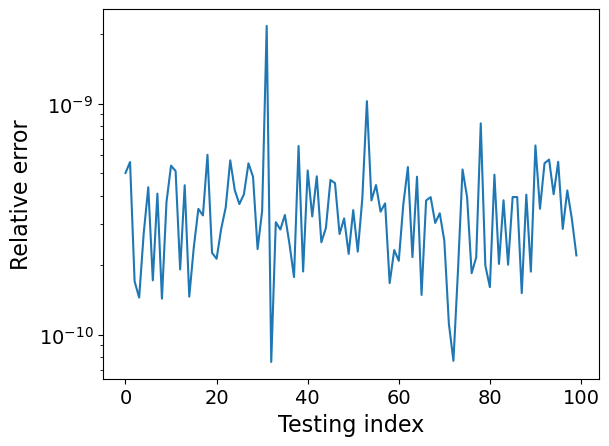

In [7]:
mu_test = -1. + 0.99*np.random.rand(100,2)

Ft = np.zeros((N, 100))
for j in range(100):
    Ft[:,j] = F(xpts, mu_test[j,:])

Fr = u @ np.linalg.solve(u[p,:], Ft[p])

err = np.zeros((mu_test.shape[0],))
for j in range(mu_test.shape[0]):
    err[j] = np.linalg.norm(Fr[:,j]-Ft[:,j])/np.linalg.norm(Ft[:,j])

plt.semilogy(range(100),err)

plt.xlabel('Testing index', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

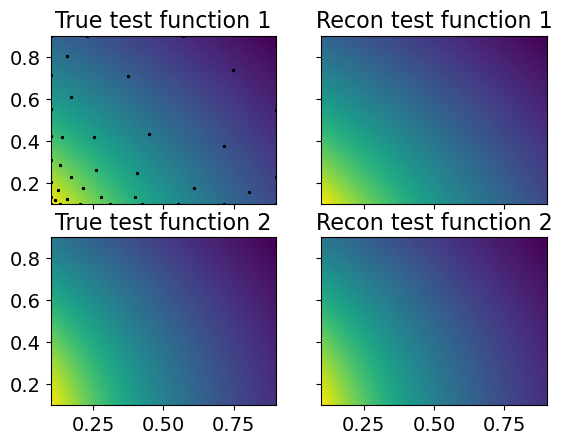

In [8]:
fig, axarray = plt.subplots(2,2,sharex=True,sharey=True)
axarray[0,0].pcolormesh(X, Y, Ft[:,0].reshape(n,n), shading='gouraud')
axarray[0,0].set_title('True test function 1', fontsize= 16)
axarray[0,1].pcolormesh(X, Y, Fr[:,0].reshape(n,n), shading='gouraud')
axarray[0,1].set_title('Recon test function 1', fontsize= 16)
axarray[1,0].pcolormesh(X, Y, Ft[:,1].reshape(n,n), shading='gouraud')
axarray[1,0].set_title('True test function 2', fontsize= 16)
axarray[1,1].pcolormesh(X, Y, Fr[:,1].reshape(n,n), shading='gouraud')
axarray[1,1].set_title('Recon test function 2', fontsize= 16)
axarray[0,0].plot(xpts[p,0], xpts[p,1], 'k*', markersize=2)
